# HOTEL BUSINESS INSIGHT

## Introduction
Sangat penting bagi suatu perusahaan untuk selalu menganalisa performa bisnisnya. Pada kesempatan kali ini, kita akan lebih mendalami bisnis dalam bidang perhotelan. Fokus yang kita tuju adalah untuk mengetahui bagaimana perilaku pelanggan kita dalam melakukan pemesanan hotel, dan hubungannya terhadap tingkat pembatalan pemesanan hotel. Hasil dari insight yang kita temukan akan kita sajikan dalam bentuk data visualisasi agar lebih mudah dipahami dan bersifat lebih persuasif.

sumber code:
https://www.kaggle.com/code/shrutidandagi/hotel-booking-demand-eda-data-visualisation

## Importing Necessary Libraries and Dataset

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy
from scipy.stats import chi2_contingency 
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from statistics import stdev
from pprint import pprint
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
sns.set_context("notebook")

In [2]:
df = pd.read_csv('hotel_bookings_data.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_weekdays_nights,adults,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
0,Resort Hotel,0,342,2017,September,27,1,0,0,2,...,3,No Deposit,NaN,NaN,0,Personal,0.0,0,0,Check-Out
1,Resort Hotel,0,737,2017,September,27,1,0,0,2,...,4,No Deposit,NaN,NaN,0,Personal,0.0,0,0,Check-Out
2,Resort Hotel,0,7,2017,September,27,1,0,1,1,...,0,No Deposit,NaN,NaN,0,Personal,75.0,0,0,Check-Out
3,Resort Hotel,0,13,2017,September,27,1,0,1,1,...,0,No Deposit,304.0,NaN,0,Personal,75.0,0,0,Check-Out
4,Resort Hotel,0,14,2017,September,27,1,0,2,2,...,0,No Deposit,240.0,NaN,0,Personal,98.0,0,1,Check-Out


### Data Cleaning

In [4]:
# Check Missing Value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_weekdays_nights        119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

terdapat beberapa feature yang memiliki data kosong, yaitu kolom `city`, `agent`, `company`, `children`

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_weekdays_nights               0
adults                                 0
children                               4
babies                                 0
meal                                   0
city                                 488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type   

### Handling missing Value

In [6]:
# Company memiliki 94% missing value, jadi akan didrop 
df.drop(columns=['company'],inplace=True)

In [7]:
# missing value pada agent akan diisi dengan nilai 0
df[['agent']]=df[['agent']].fillna(0)

In [8]:
# missing value pada city akan diisi dengan others
df[['city']]= df[['city']].fillna('others')

In [9]:
# missing value children akan diisi dengan mean
df[['children']]=df[['children']].fillna(df['children'].mean())

In [10]:
# dalam kolom meal terdapat 'undifined' yang sama artinya dengan 'SC', merubah 'undifined' menjadi 'SC'
df['meal'].replace('Undefined','SC', inplace=True)

In [11]:
df['meal'].value_counts()

Breakfast     92310
Dinner        14463
No Meal       10650
SC             1169
Full Board      798
Name: meal, dtype: int64

In [12]:
# membedakan paket dengan menggunakan meal dan tidak menggunakan meal
df['meal'] = df['meal'].replace(['Breakfast', 'Dinner', 'Full Board'], 'With_Meal')
df['meal'] = df['meal'].replace(['SC', 'No Meal'], 'Without_meal')

In [13]:
df['meal'].value_counts()

With_Meal       107571
Without_meal     11819
Name: meal, dtype: int64

In [14]:
(df['adults']+df['children']+df['babies']==0).value_counts()

False    119210
True        180
dtype: int64

In [15]:
# karena terdapat kolom yang memiliki 0 adults, 0 children dan 0 babies, jadi diasumsikan sebagai zero_guests dan akan didrop
zero_guests = list(df.loc[df['adults']+df['children']+df['babies']==0].index)
df.drop(df.index[zero_guests], inplace=True)

In [16]:
df.shape

(119210, 28)

### Melihat Canceled Order di setiap jenis hotel

In [17]:
df['is_canceled'].value_counts()

0    75011
1    44199
Name: is_canceled, dtype: int64

In [18]:
x= df[df.is_canceled==1]
x=x.groupby('hotel')['is_canceled'].value_counts()
x

hotel         is_canceled
City Hotel    1              33079
Resort Hotel  1              11120
Name: is_canceled, dtype: int64

In [19]:
# Persentase cancellation di tiap jenis hotel
print('persentase Cancelled Order City Hotel' ,x['City Hotel'].sum()*100/df.shape[0],'%')
print('persentase Cancelled Order Resort Hotel' ,x['Resort Hotel'].sum()*100/df.shape[0],'%')

persentase Cancelled Order City Hotel 27.74851103095378 %
persentase Cancelled Order Resort Hotel 9.328076503649022 %


AttributeError: 'Text' object has no attribute 'containers'

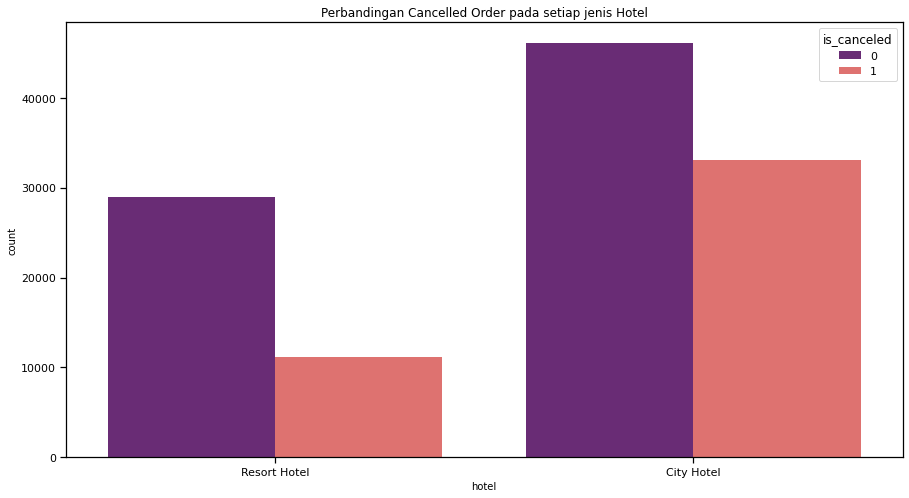

In [20]:
plt.figure(figsize= (15,8))
ax=sns.countplot(x='hotel', hue='is_canceled', data=df,palette = 'magma').set_title('Perbandingan Cancelled Order pada setiap jenis Hotel')
for i in ax.containers:
    ax.bar_label(i,)
sns


#### Monthly Hotel Booking

melihat jumlah hotel booking untuk setiap tipe

In [42]:
#Copying preprocessing data
df_monthly = df.copy()

##Creating an aggregation data by calculating the number of hotel bookings
hotel_arrival = df_monthly.groupby(['hotel', 'arrival_date_month'])['arrival_date_year'].agg(['nunique', 'count']).reset_index()
hotel_arrival

,hotel,arrival_date_month,nunique,count
0,City Hotel,April,2,4950
1,City Hotel,August,2,7885
2,City Hotel,December,2,7594
3,City Hotel,February,2,4114
4,City Hotel,January,2,4336
5,City Hotel,July,2,8221
6,City Hotel,June,2,7469
7,City Hotel,March,2,3730
8,City Hotel,May,2,6434
9,City Hotel,November,2,7392


In [43]:
#Changing the table column from the previous result
hotel_arrival.columns = ['hotel_variety', 'month_arrival', 'unique_booking_year', 'count_booking']
hotel_arrival

,hotel_variety,month_arrival,unique_booking_year,count_booking
0,City Hotel,April,2,4950
1,City Hotel,August,2,7885
2,City Hotel,December,2,7594
3,City Hotel,February,2,4114
4,City Hotel,January,2,4336
5,City Hotel,July,2,8221
6,City Hotel,June,2,7469
7,City Hotel,March,2,3730
8,City Hotel,May,2,6434
9,City Hotel,November,2,7392


pada kolom `unique_booking_year`, value bulan october dan september berbeda daripada bulan lainnya, maka dari sini kita akan melakukan normalisasi supaya nilainya sama 

In [45]:
#Normalizing data to get the average number of bookings
hotel_arrival['average_hotel_booking'] = hotel_arrival['count_booking']/hotel_arrival['unique_booking_year']

print(round(hotel_arrival['average_hotel_booking']))

0     2475.0
1     3942.0
2     3797.0
3     2057.0
4     2168.0
5     4110.0
6     3734.0
7     1865.0
8     3217.0
9     3696.0
10    2989.0
11    2690.0
12    1551.0
13    1522.0
14    1776.0
15    1322.0
16    1218.0
17    1780.0
18    1804.0
19    1096.0
20    1667.0
21    1554.0
22    1631.0
23    1524.0
Name: average_hotel_booking, dtype: float64


In [46]:
#Sorting an alphabetically names of the months
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
hotel_arrival["month"] = hotel_arrival["month_arrival"].str[:3]
hotel_arrival["month"] = pd.Categorical(hotel_arrival["month"], categories=months, ordered=True)

In [47]:
hotel_arrival

,hotel_variety,month_arrival,unique_booking_year,count_booking,average_hotel_booking,month
0,City Hotel,April,2,4950,2475.000000,Apr
1,City Hotel,August,2,7885,3942.500000,Aug
2,City Hotel,December,2,7594,3797.000000,Dec
3,City Hotel,February,2,4114,2057.000000,Feb
4,City Hotel,January,2,4336,2168.000000,Jan
5,City Hotel,July,2,8221,4110.500000,Jul
6,City Hotel,June,2,7469,3734.500000,Jun
7,City Hotel,March,2,3730,1865.000000,Mar
8,City Hotel,May,2,6434,3217.000000,May
9,City Hotel,November,2,7392,3696.000000,Nov


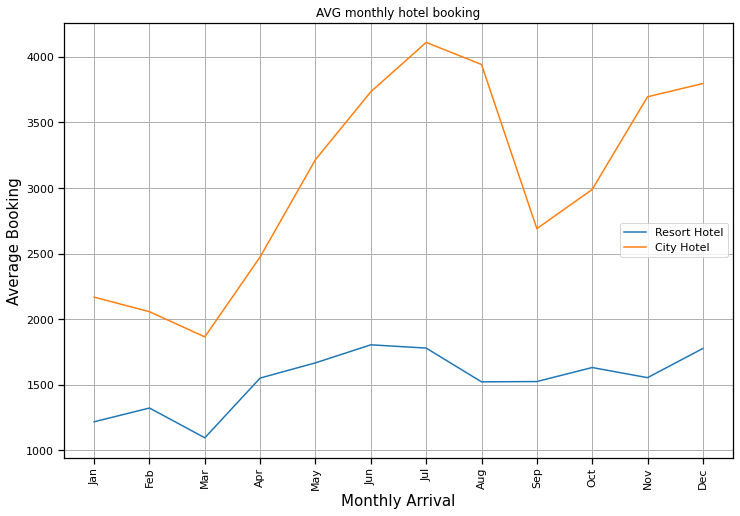

In [56]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

sns.lineplot(x='month', y='average_hotel_booking', data=hotel_arrival, hue="hotel_variety", hue_order=["Resort Hotel","City Hotel"]).set(xlabel=None)
plt.ylabel('Average Booking', fontsize = 15)
plt.xlabel('Monthly Arrival', fontsize = 15)
plt.title('AVG monthly hotel booking')
plt.grid()
plt.legend(loc="center right")
plt.xticks(rotation=90);

<module 'seaborn' from 'C:\\Users\\ASUS\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

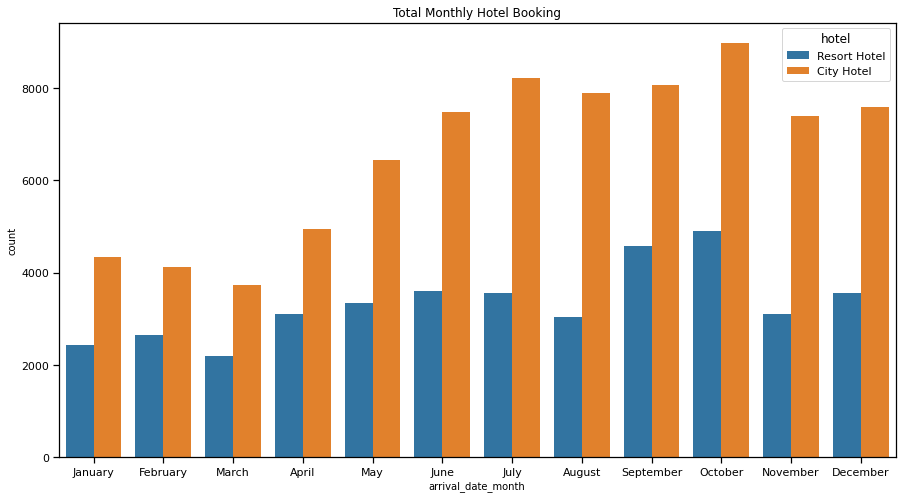

In [57]:
#selanjutnya kita ingin mengetahui, pada bulan apa perubahan jumlah pengunjung yang terjadi
plt.figure(figsize= (15,8))
Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(x='arrival_date_month', hue='hotel', data=df, order=Months)
plt.title('Total Monthly Hotel Booking')
sns

Pada bulan Juni dan Juli jumlah pengunjung di kedua tipe hotel memiliki pengunjung terbanyak, hal ini dikarenakan pada bulan tersebut merupakan masa liburan sekolah. sedangkan pada bulan agustus dan september memiliki penurunan yang sangat tajam dikarenakan pada bulan itu adalah waktu berakhirnya masa liburan sekolah. 
Sedangkan pada bulan November-Desember terjadi kenaikan jumlah pengunjung di kedua hotel dikarenakan adanya libur akhir tahun dan libur Nataru(natal dan tahun baru). Pada periode Januari-Maret jumlah pengunjung di kedua hotel memiliki nilai paling rendah dikarenakan pada masa masa ini tidak adanya libur panjang, sehingga tidak banyak orang yang memutuskan untuk bepergian/liburan


<module 'seaborn' from 'C:\\Users\\ASUS\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

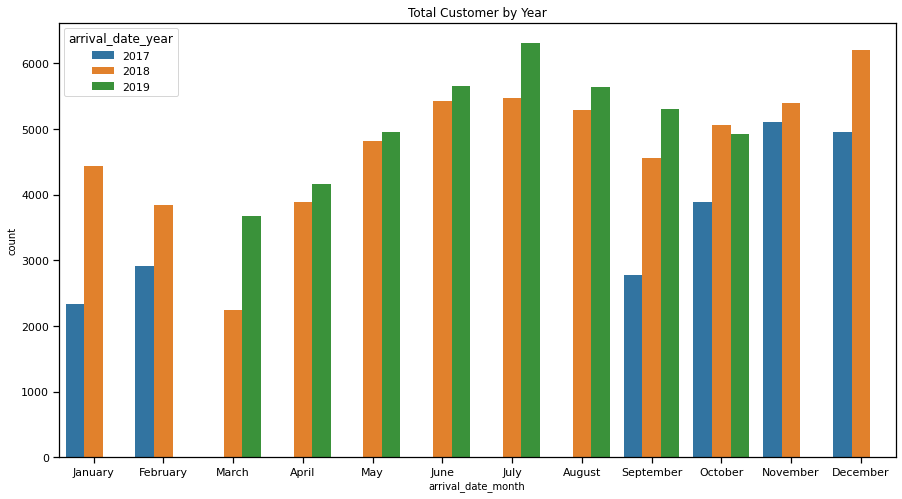

In [58]:
#selanjutnya kita ingin mengetahui, pada tahun berapa perubahan jumlah pengunjung yang terjadi
plt.figure(figsize= (15,8))
Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(x='arrival_date_month', hue='arrival_date_year', data=df, order=Months)
plt.title('Total Customer by Year')
sns

Jumlah pengunjung hotel setiap tahunnya terus berkurang dari tahun 2017 sampai 2019. 

<module 'seaborn' from 'C:\\Users\\ASUS\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

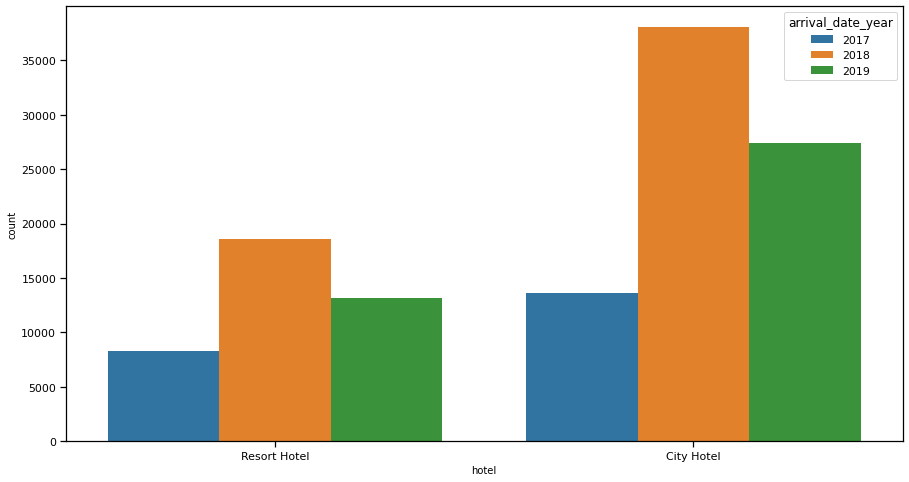

In [23]:
# pengunjung yang membawa anak-anak dan bayi di setiap jenis hotel
plt.figure(figsize= (15,8))
sns.countplot(x='hotel', hue='arrival_date_year', data=df)
sns

### EDA

In [24]:
fig=make_subplots(rows=1, cols=2, 
                  subplot_titles=("", "Jenis Hotel"),
                  specs=[[{"type": "bar"}, {"type": "pie"}]])

plot_df=df['is_canceled'].value_counts(normalize=True)
plot_df=plot_df.mul(100).rename('Percent').reset_index().sort_values('Percent')
plot_df.rename(columns={'index':'is_canceled'}, inplace=True)
plot_df['is_canceled']=['No Canceled' if i == '0' else 'Canceled' for i in plot_df['is_canceled']]
x=plot_df['is_canceled']
y=plot_df['Percent']
fig.add_trace(
    go.Bar(x=x, y=y, text=y,opacity=.8,
           hovertemplate='is_canceled<br>%{x}: %{y:.3}%<extra></extra>',
           showlegend=False), row=1, col=1)
fig.update_traces(texttemplate='%{text:.3s}%', textposition='outside', 
                  marker_line=dict(width=1, color='#1F0202'), marker_color=['#C02B34','#CDBBA7'])
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='gray')
fig.update_layout(yaxis_ticksuffix = '%')

# Pie chart
plot_df2=df
plot_df2=plot_df2['hotel'].value_counts(normalize=True)
plot_df2=plot_df2.mul(100).rename('Percent').reset_index().sort_values('Percent', ascending=False)
plot_df2.rename(columns={'index':'hotel'}, inplace=True)
fig.add_trace(go.Pie(labels=plot_df2['hotel'], values=plot_df2['Percent'], opacity=0.85, hole=0.4,
                     hovertemplate='%{label}<br>hotel: %{value:.3}%<extra></extra>',
                     marker_colors=['#587D65','#ADC4B2','#D1C9C2']), row=1, col=2)
fig.update_yaxes(tickmode = 'array', range=[0, 90], dtick=5)
fig.update_traces(textfont_size=14,textfont_color='black',marker=dict(line=dict(color='#28221D', width=1)))
fig.update_layout(title_text="Hotel Canceled and type of hotel", font_color='#28221D',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')      
fig.show()

kita dapat mengetahui bahwa `City Hotel` memiliki persentase lebih banyak daripada `Resort Hotel`

In [25]:
plot_df1 = df.groupby(['hotel'])['arrival_date_month'].value_counts(normalize=True)


In [26]:
#plot_df = df.groupby(['arrival_date_month', 'hotel'])['is_canceled'].value_counts()
#plot_df = plot_df.mul(100).rename('Percent').reset_index()
#fig = px.bar(plot_df, x='arrival_date_month', y='count' ,color='hotel', barmode='group')

# Jumlah Cancel Order di setiap bulannya
plot_df = df.groupby(['arrival_date_month', 'hotel'])['is_canceled'].value_counts()
plot_df = plot_df.mul(1).rename('Count').reset_index()
fig = px.bar(plot_df, x="arrival_date_month", y="Count", color="is_canceled", barmode="group",
            text='Count', opacity=.75,facet_col="hotel", category_orders={'is_canceled': ['0', '1']},
            color_discrete_map={'0': '#C02B34','1': '#CDBBA7'}) 
fig.update_traces(texttemplate='%{text:.3s}%', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'),  width=.4)
fig.update_layout(title_text='Perbandingan Jumlah Cancel Hotel perbulan', yaxis_ticksuffix = '',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0',font_color='#28221D',
                  height=500, xaxis=dict(tickangle=30))
fig.update_xaxes(showticklabels=True,tickangle=30,col=2)
fig.update_yaxes(title = "", zeroline=True, zerolinewidth=1, zerolinecolor='#28221D')
fig.show()

### Next analisis

<Axes: title={'center': 'Top 5 City'}>

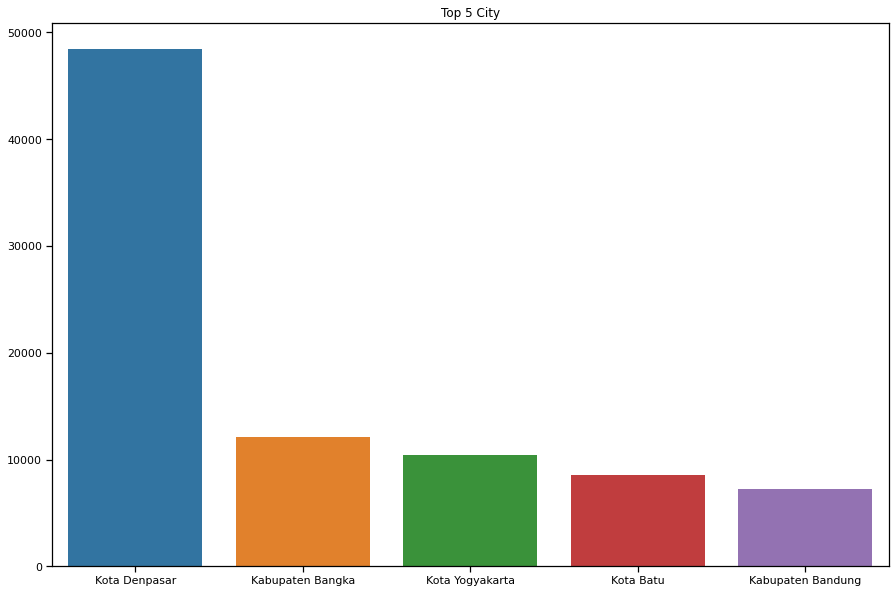

In [27]:
# from dataprep.clean import clean_country
fig, ax = plt.subplots(figsize = (15,10))
ax.set_title('Top 5 City')
fig.show()
top_five = df.city.value_counts()[0:5]
# cleaned = clean_country(top_ten.reset_index(),'index')[['country','index_clean']]
sns.barplot(x=top_five.index, y=top_five.values)

Kota Denpasar merupakan tujuan destinasi wisata favorit bagi wisatawan, sedangkan Kabupaten Bangka dan Kota Yogyakarta merupakan destinasi favorit setelah kota Denpasar 

In [127]:
# Total waktu menginap pengunjung
df['Jumlah_Waktu_menginap']= df['stays_in_weekdays_nights']+ df['stays_in_weekend_nights']
df_menginap = df.copy()

In [128]:
df_menginap['Jumlah_Waktu_menginap'].describe()

count    119210.000000
mean          3.426248
std           2.540692
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          69.000000
Name: Jumlah_Waktu_menginap, dtype: float64

In [129]:
# Membuat kolom baru 'durasi_menginap_group'
df_menginap['durasi_menginap_group'] = np.where(df_menginap['Jumlah_Waktu_menginap'] > 21, 21, 
                                       np.where(df_menginap['Jumlah_Waktu_menginap'] > 14, 15, df_menginap['Jumlah_Waktu_menginap']))

# Menampilkan frekuensi dari setiap kelompok durasi menginap
print(df_menginap['durasi_menginap_group'].value_counts())

2     27632
3     27064
1     21005
4     17373
7      8648
5      7771
6      3846
8      1155
10     1135
14      913
9       840
0       645
11      393
15      274
12      220
21      155
13      141
Name: durasi_menginap_group, dtype: int64


In [152]:
df_menginap.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_weekdays_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,Jumlah_Waktu_menginap,durasi_menginap_group
0,Resort Hotel,0,342,2017,September,27,1,0,0,2,...,No Deposit,0.0,0,Personal,0.0,0,0,Check-Out,0,0
1,Resort Hotel,0,737,2017,September,27,1,0,0,2,...,No Deposit,0.0,0,Personal,0.0,0,0,Check-Out,0,0
2,Resort Hotel,0,7,2017,September,27,1,0,1,1,...,No Deposit,0.0,0,Personal,75.0,0,0,Check-Out,1,1
3,Resort Hotel,0,13,2017,September,27,1,0,1,1,...,No Deposit,304.0,0,Personal,75.0,0,0,Check-Out,1,1
4,Resort Hotel,0,14,2017,September,27,1,0,2,2,...,No Deposit,240.0,0,Personal,98.0,0,1,Check-Out,2,2


In [131]:
# Agregat Perbandingan jumlah pesanan hotel yang dibatalkan terhadap durasi menginap untuk setiap jenis hotel
#df_agg = df.groupby(['hotel','durasi_menginap_group'])['is_canceled'].value_counts().reset_index(name='count_booking')

In [132]:
#df_agg

In [148]:
df_agg = df_menginap.groupby(['hotel', 'is_canceled', 'durasi_menginap_group'])['arrival_date_month'].count().reset_index(name='count_booking')
df_agg.head()

,hotel,is_canceled,durasi_menginap_group,count_booking
0,City Hotel,0,0,251
1,City Hotel,0,1,9155
2,City Hotel,0,2,10983
3,City Hotel,0,3,11889
4,City Hotel,0,4,7694


In [149]:
df1_agg = df_agg.pivot_table(index=['hotel', 'durasi_menginap_group'], columns='is_canceled', values='count_booking').reset_index()
df1_agg.head()

is_canceled,hotel,durasi_menginap_group,0,1
0,City Hotel,0,251,13
1,City Hotel,1,9155,4103
2,City Hotel,2,10983,10432
3,City Hotel,3,11889,9482
4,City Hotel,4,7694,4853


In [150]:
df1_agg.head()

is_canceled,hotel,durasi_menginap_group,0,1
0,City Hotel,0,251,13
1,City Hotel,1,9155,4103
2,City Hotel,2,10983,10432
3,City Hotel,3,11889,9482
4,City Hotel,4,7694,4853


In [151]:
#df1_agg.columns = ['is_canceled', 'hotel_type', 'durasi_menginap_group', 'no_canceled', 'are_canceled']
df1_agg = df1_agg.rename(columns={0: 'no_canceled', 1: 'are_canceled'})
df1_agg.head()

is_canceled,hotel,durasi_menginap_group,no_canceled,are_canceled
0,City Hotel,0,251,13
1,City Hotel,1,9155,4103
2,City Hotel,2,10983,10432
3,City Hotel,3,11889,9482
4,City Hotel,4,7694,4853


In [137]:
#df1_agg['bookings'] = df1_agg['no_canceled']+df1_agg['are_canceled']
#df1_agg

In [138]:
#df1_agg['count_canceled'] = df1_agg['are_canceled']*100.0/(df1_agg['bookings'])
#df1_agg

In [139]:
df1_agg['count_canceled'] = round(df1_agg['are_canceled']*100.0/(df1_agg['no_canceled']+df1_agg['are_canceled']), 2)
df1_agg.head()

is_canceled,hotel,durasi_menginap_group,no_canceled,are_canceled,count_canceled
0,City Hotel,0,251,13,4.92
1,City Hotel,1,9155,4103,30.95
2,City Hotel,2,10983,10432,48.71
3,City Hotel,3,11889,9482,44.37
4,City Hotel,4,7694,4853,38.68


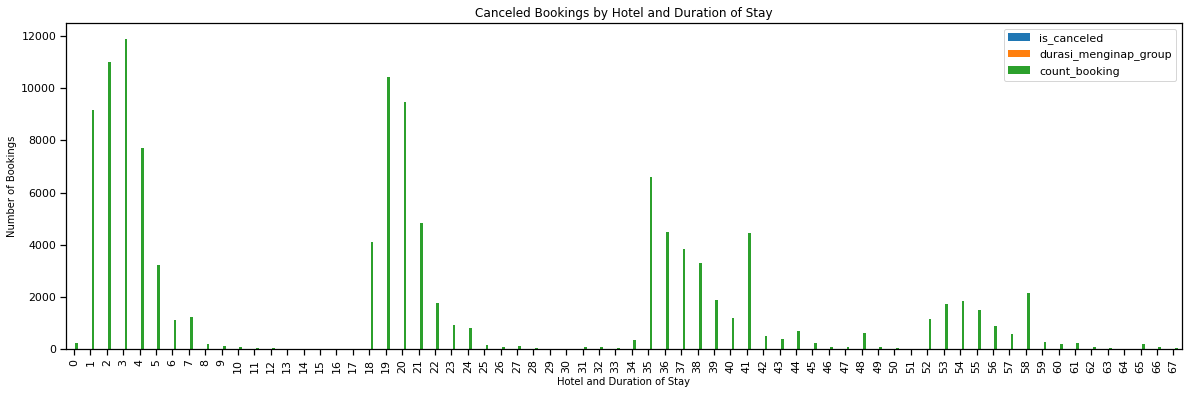

In [140]:
# rasio pembatalan pesanan terhadap durasi menginap untuk setiap tipe hotel
# Reshape the data from the Series to a DataFrame
df_agg = df_menginap.groupby(['hotel', 'is_canceled', 'durasi_menginap_group'])['arrival_date_month'].count().reset_index(name='count_booking')
df1_agg = df_agg.pivot_table(index=['hotel', 'durasi_menginap_group'], columns='is_canceled', values='count_booking').reset_index()
df1_agg.columns = ['hotel_type', 'durasi_menginap_group', 'no_canceled', 'are_canceled']
df1_agg['bookings'] = df1_agg['no_canceled']+df1_agg['are_canceled']
#df1_agg['count_canceled'] = df1_agg['are_canceled']*100.0/(df1_agg['bookings'])
df1_agg['count_canceled'] = round(df1_agg['are_canceled']*100.0/(df1_agg['no_canceled']+df1_agg['are_canceled']), 2)


# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(20, 6))
df_agg.plot(kind='bar', ax=ax)

# Set the chart title and axis labels
ax.set_title('Canceled Bookings by Hotel and Duration of Stay')
ax.set_xlabel('Hotel and Duration of Stay')
ax.set_ylabel('Number of Bookings')

# Display the chart
plt.show()

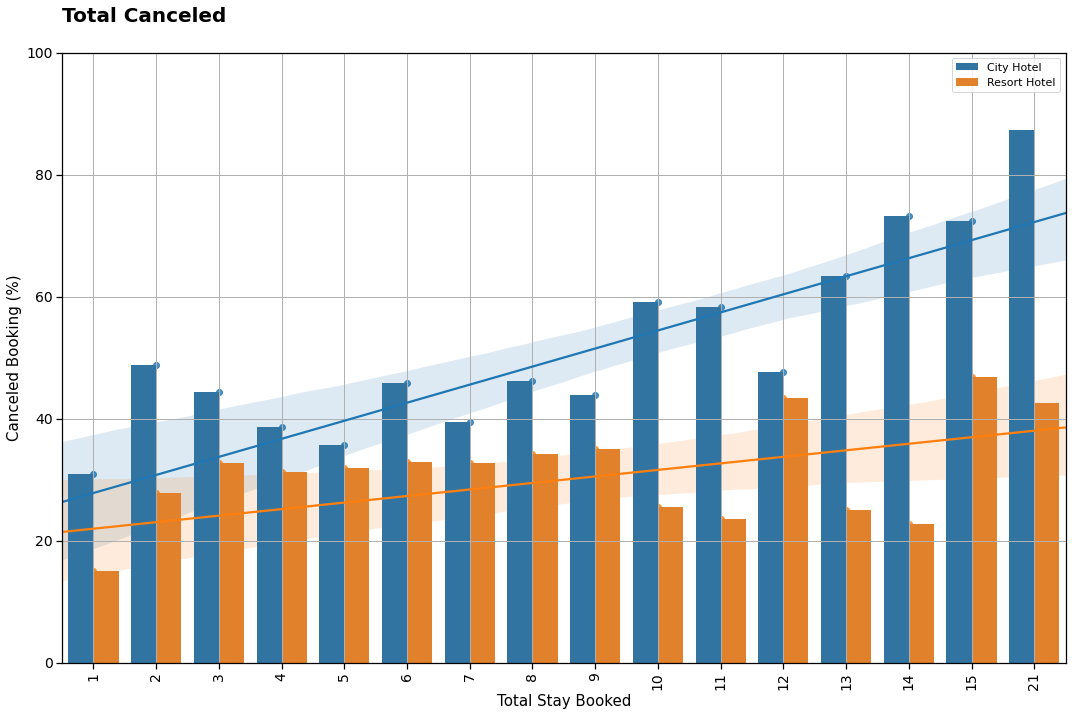

In [141]:
plt.figure(figsize=(15,10))
sns.regplot(x='durasi_menginap_group', y='count_canceled', data=df1_agg[df1_agg['hotel_type'] == 'City Hotel'], scatter=True)
sns.regplot(x='durasi_menginap_group', y='count_canceled', data=df1_agg[df1_agg['hotel_type'] == 'Resort Hotel'], scatter=True)
sns.barplot(x='durasi_menginap_group', y='count_canceled', hue='hotel_type', data=df1_agg, alpha=1)

plt.tick_params(axis='both', which='major', labelsize=14) 
plt.grid()
plt.legend(title='Hotel Type', title_fontsize=15, prop={'size':13}) 

plt.xlabel('Total Stay Booked', fontsize=15)  
plt.ylabel('Canceled Booking (%)', fontsize=15) 
plt.ylim(0, 100) 
plt.xlim(0.5, 16.5) 

plt.text(x=0.5, y=105, s="Total Canceled", 
         fontsize=20, fontweight='bold') 

plt.legend(loc="upper right")
plt.xticks(rotation=90);
plt.tight_layout()

berdasarkan Grafik, kita dapat mengetahui canceled rate dari tiap jenis hotel dan lamanya waktu menginap. semakin lama waktu menginapnya, semakin tinggi pula canceled ratenya, baik itu di City Hotel maupun di Resort Hotel. akan tetapi canceled rate  City Hotel lebih besar daripada Resort Hotel. 

Dapat dilihat juga, jumlah pengunjung city hotel lebih banyak dibandingkan dengan Resrt Hotel, karena City Hotel lebih mudah dijangkau secara jarak dibandingkan dengan Resort Hotel. sehingga pengunjung lebih memilih untuk menempati City Hotel daripada Resrt Hotel. hall ini disebabkan juga karena modal transportasi untuk mencapai hotel tersebut. City Hotel lebih dapat dijangkau dengan kendaraan umum, sedangkan Resort Hotel memerlukan biaya tambahan untuk menyewa kendaraan ataupun membawa kendaraan pribadi.

### Analisis Lead Time dan Canceled Rate

In [142]:
df_next = df_menginap.copy()

<Axes: xlabel='lead_time', ylabel='Count'>

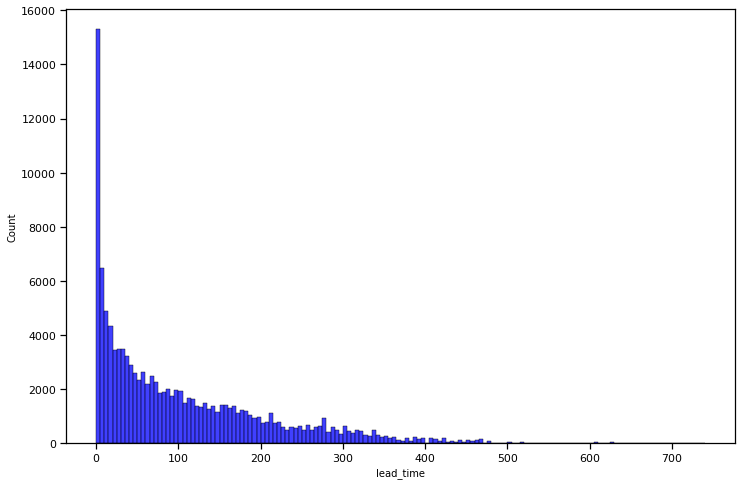

In [144]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

sns.histplot(data=df_next, x="lead_time", binwidth=5, color="blue")

In [145]:
df_next['lead_all_time'] = np.where(df_menginap['lead_time'] > 450, 451, df_next['lead_time'])
bins = list(np.arange(0,max(df_next['lead_all_time'])+30, 30))
labels = ["{0}-{1}".format(str(bins[x]), str(bins[x+1])) for x in range(len(bins[:-1]))]
df_next['lead_time_category'] = pd.cut(df_next['lead_all_time'],bins=bins, include_lowest=True, labels=labels)

In [146]:
df3_next = df_next.groupby(['hotel', 'lead_time_category', 'is_canceled'])['arrival_date_month'].count().reset_index(name='count_booking')
df3_agg = df3_next.pivot_table(index=['hotel', 'lead_time_category'], columns='is_canceled', values='count_booking').reset_index()
df3_agg.columns = ['hotel_type', 'lead_time_category', 'no_canceled', 'are_canceled']
df3_agg['bookings'] = df3_agg['no_canceled']+df3_agg['are_canceled']
df3_agg['count_canceled'] = df3_agg['are_canceled']*100.0/(df3_agg['bookings'])

df3_agg.head()

,hotel_type,lead_time_category,no_canceled,are_canceled,bookings,count_canceled
0,City Hotel,0-30,18060,5184,23244,22.302530
1,City Hotel,30-60,7266,4608,11874,38.807479
2,City Hotel,60-90,5210,3692,8902,41.473826
3,City Hotel,90-120,3956,3486,7442,46.842247
4,City Hotel,120-150,3064,2542,5606,45.344274


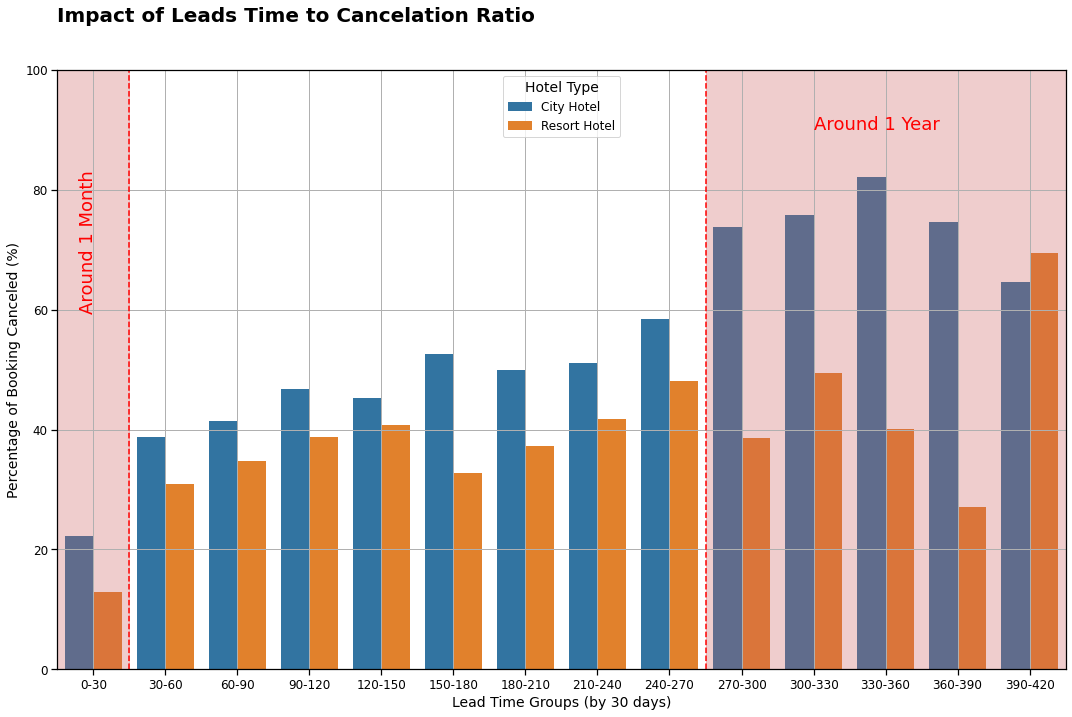

In [147]:
plt.figure(figsize=(15,10)) 
sns.barplot(x='lead_time_category', y='count_canceled', hue='hotel_type', data=df3_agg) 

plt.tick_params(axis='both', which='major', labelsize=12) 
plt.grid() 
plt.legend(title='Hotel Type', title_fontsize=14, prop={'size':12}, loc=9) 

plt.xlabel('Lead Time Groups (by 30 days)', fontsize=14) 
plt.ylabel('Percentage of Booking Canceled (%)', fontsize=14)  
plt.ylim(0, 100) 
plt.xlim(-0.5,13.5) 

plt.axvline(0.5, ls='--', color='red') 
plt.text(x=-0.2, y=60, s='Around 1 Month', fontsize=18, color='red', rotation=90) 
plt.stackplot(np.arange(-0.5,1.5,1), [[100]], color='indianred', alpha=0.3) 

plt.axvline(8.5, ls='--', color='red') 
plt.text(x=10, y=90, s='Around 1 Year', fontsize=18, color='red') 
plt.stackplot(np.arange(8.5,14.5,1), [[100]], color='indianred', alpha=0.3) 

plt.text(x=-0.5, y=108, s="Impact of Leads Time to Cancelation Ratio", 
         fontsize=20, fontweight='bold') 
 
plt.tight_layout() 

Canceled rate terendah terjadi pada 0-30 hari dari waktu customer memesan hotel. Canceled rate dengan waktu booking yang lama, sekitar 270-420 hari memiliki canceled rate sekitar 40% untuk Resort Hotel dan sekitar 60% untuk City Hotel.